In [20]:
import os
import glob
from sklearn.model_selection import train_test_split
import numpy as np

import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers, losses

tf.enable_eager_execution()
tf.VERSION

'1.13.1'

# Set up

In [3]:
common_root = r'/awlab/users/chsu/WorkSpace/tensorflow/segmentation/data/plate_2017017086_ki67'

img_dir = os.path.join(common_root, 'images')
mask_dir = os.path.join(common_root, 'masks')

In [17]:
x_train_fnames = sorted(glob.glob(os.path.join(img_dir,'*-2.png'))) # nucleus images
y_train_fnames = sorted(glob.glob(os.path.join(mask_dir,'*_nucleus.jpeg'))) # nucleus masks     


# Split into training and validation
x_train_fnames, x_val_fnames, y_train_fnames, y_val_fnames = train_test_split(x_train_fnames, y_train_fnames, 
                                                                              test_size=0.2, random_state=43)

num_train_data = len(x_train_fnames)
num_val_data = len(x_val_fnames)

print("Number of training samples: {}".format(num_train_data))
print("Number of validation samples: {}".format(num_val_data))

Number of training samples: 388
Number of validation samples: 98


In [63]:
idx = np.random.choice(num_train_data)
print(os.path.basename(x_train_fnames[idx]))
print(os.path.basename(y_train_fnames[idx]))

CH_171219_Vh31_Goldilocks_plate_2017017086_ki67_F9_0000-2.png
CH_171219_Vh31_Goldilocks_plate_2017017086_ki67_F9_0000_nucleus.jpeg


# Build the input pipeline

In [64]:
def _get_image_from_path(img_path, mask_path):
    img = tf.image.decode_png(tf.read_file(img_path), channels=1, dtype=tf.uint16)
    mask = tf.image.decode_jpeg(tf.read_file(mask_path), channels=1)
    
    return img, mask

In [65]:
print(img.shape)

(1080, 1280, 1)


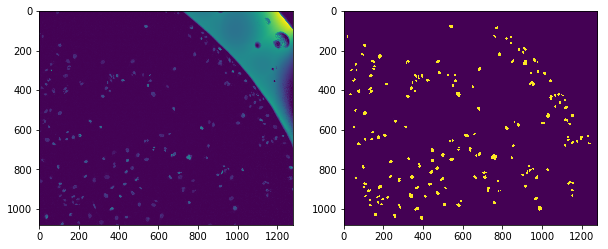

In [70]:
idx = np.random.choice(num_train_data)
img, mask = _get_image_from_path(x_train_fnames[idx], y_train_fnames[idx])

plt.figure(figsize=(10,15))
plt.subplot(1,2,1)
plt.imshow(img[:,:,0])
plt.subplot(1,2,2)
plt.imshow(mask[:,:,0])